<a href="https://colab.research.google.com/github/vigneshm1995/BDIA-Project/blob/master/GAN%20Training%20Notebooks/BDIA_Project_Malaria_Change_HyperParams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BDIA Project Changing Hyperparams

In [0]:
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
!mkdir generated_images
!mkdir generated_test_images
!mkdir gen_imgs
!mkdir saved_models


--2019-04-20 18:27:12--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   157MB/s    in 2.1s    

2019-04-20 18:27:14 (157 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [0]:
import zipfile
path_to_zip_file = "cell_images.zip"
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall()

In [0]:
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
import tensorflow as tf
from keras.optimizers import Adam,SGD
from PIL import Image
import numpy as np
from tqdm import tqdm

## Viewing cell data

In [0]:
import os
import random
import matplotlib.pyplot as plt
input_directory = "cell_images"
output_directory = r"../output/"

training_dir = input_directory
# testing_dir = input_directory + r"test"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "../output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

In [0]:
!rm cell_images/Parasitized/Thumbs.db

rm: cannot remove 'cell_images/Parasitized/Thumbs.db': No such file or directory


In [0]:


def plot_image(file, directory=None, sub=False, aspect=None):
    path = directory + file
    
    img = plt.imread(path)
    
    plt.imshow(img, aspect=aspect)
#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
        
def plot_img_dir(directory=training_dir, count=5):
    selected_files = random.sample(os.listdir(directory), count)
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in selected_files:        
        plt.subplot(nrows, ncols, i+1)
        path = directory + file
        plot_image(file, directory, aspect=None)

        i=i+1
    
    plt.tight_layout()
    plt.show()
    
def plot_img_dir_main(directory=training_dir, count=5):
    labels = os.listdir(directory)
    for label in labels:
        print(label)
        plot_img_dir(directory=directory+"/"+label+"/", count=count)
        



Parasitized


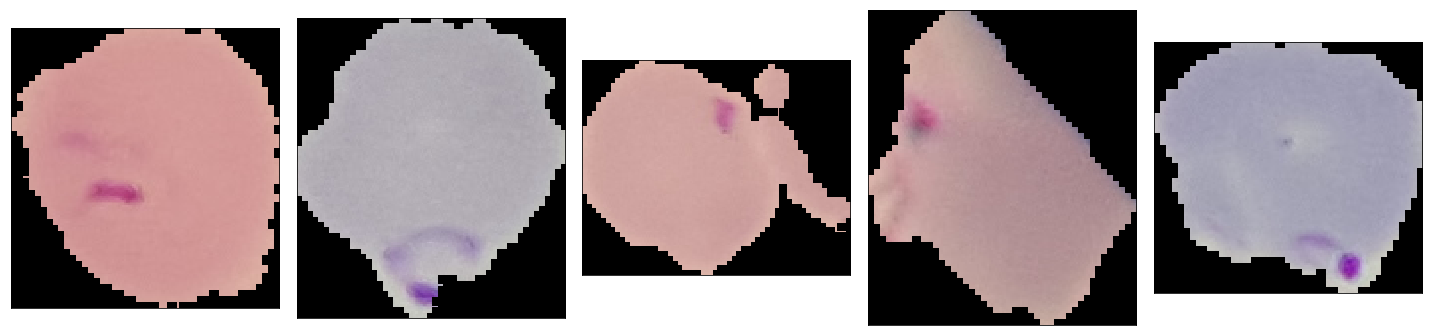

Uninfected


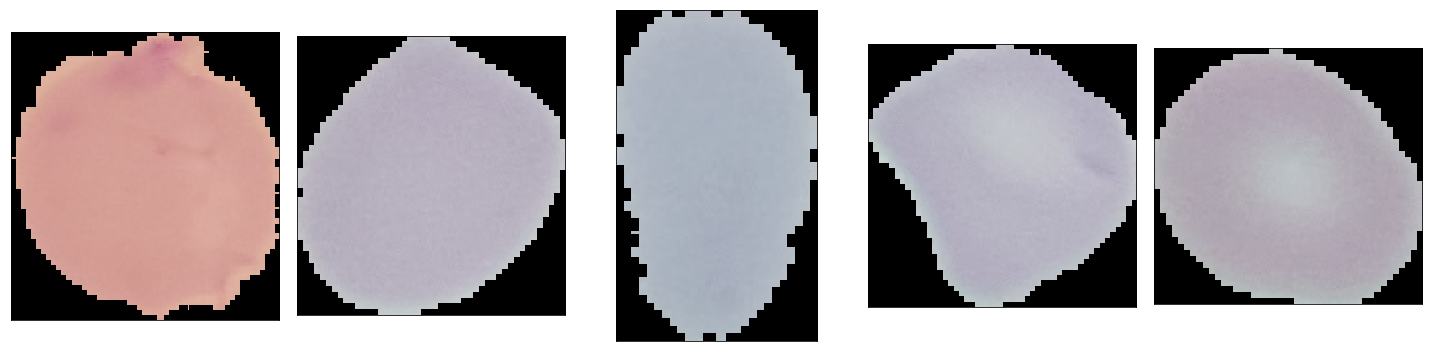

In [0]:
plot_img_dir_main(directory=training_dir, count=5)

## Building dataset

In [0]:
def get_training_data(datafolder):
        print("Loading training data...")

        training_data = []
        #Finds all files in datafolder
        filenames = os.listdir(datafolder)
        for filename in tqdm(filenames):
            #Combines folder name and file name.
            path = os.path.join(datafolder,filename)
            #Opens an image as an Image object.
            image = Image.open(path)
            #Resizes to a desired size.
            image = image.resize((image_width,image_height),Image.ANTIALIAS)
            #Creates an array of pixel values from the image.
            pixel_array = np.asarray(image)

            training_data.append(pixel_array)

        #training_data is converted to a numpy array
        training_data = np.reshape(training_data,(-1,image_width,image_height,channels))
        return training_data

# Creating GAN [Generator and Discriminator]

Changing hyperparameters:

- Increased hidden units
- Added dropout (doubled dropout in discriminator)
- Using SGD optimization

In [0]:
    def build_generator():
        #Generator attempts to fool discriminator by generating new images.
        model = Sequential()

        model.add(Dense(256*4*4,activation="relu",input_dim=random_noise_dimension))
        model.add(Reshape((4,4,256)))

        #Four layers of upsampling, convolution, batch normalization and activation.
        # 1. Upsampling: Input data is repeated. Default is (2,2). In that case a 4x4x256 array becomes an 8x8x256 array.
        # 2. Convolution: If you are not familiar, you should watch this video: https://www.youtube.com/watch?v=FTr3n7uBIuE
        # 3. Normalization normalizes outputs from convolution.
        # 4. Relu activation:  f(x) = max(0,x). If x < 0, then f(x) = 0.


        model.add(UpSampling2D())
        model.add(Conv2D(512,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Dropout(0.5))

        model.add(UpSampling2D())
        model.add(Conv2D(512,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Dropout(0.5))

        model.add(UpSampling2D())
        model.add(Conv2D(256,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Dropout(0.5))

        model.add(UpSampling2D())
        model.add(Conv2D(256,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Dropout(0.5))


        # Last convolutional layer outputs as many featuremaps as channels in the final image.
        model.add(Conv2D(channels,kernel_size=3,padding="same"))
        # tanh maps everything to a range between -1 and 1.
        model.add(Activation("tanh"))

        # show the summary of the model architecture
        model.summary()

        # Placeholder for the random noise input
        input = Input(shape=(random_noise_dimension,))
        #Model output
        generated_image = model(input)

        #Change the model type from Sequential to Model (functional API) More at: https://keras.io/models/model/.
        return Model(input,generated_image)


    def build_discriminator():
        #Discriminator attempts to classify real and generated images
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
        #Leaky relu is similar to usual relu. If x < 0 then f(x) = x * alpha, otherwise f(x) = x.
        model.add(LeakyReLU(alpha=0.2))

        #Dropout blocks some connections randomly. This help the model to generalize better.
        #0.25 means that every connection has a 25% chance of being blocked.
        model.add(Dropout(0.50))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        #Zero padding adds additional rows and columns to the image. Those rows and columns are made of zeros.
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.50))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.50))
        model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.50))
        model.add(Conv2D(1024, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.50))
        #Flatten layer flattens the output of the previous layer to a single dimension.
        model.add(Flatten())
        #Outputs a value between 0 and 1 that predicts whether image is real or generated. 0 = generated, 1 = real.
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        input_image = Input(shape=image_shape)

        #Model output given an image.
        validity = model(input_image)

        return Model(input_image, validity)

In [0]:
def train(datafolder ,epochs,batch_size,save_images_interval):
        #Get the real images
        training_data = get_training_data(datafolder)

        #Map all values to a range between -1 and 1.
        training_data = training_data / 127.5 - 1.

        #Two arrays of labels. Labels for real images: [1,1,1 ... 1,1,1], labels for generated images: [0,0,0 ... 0,0,0]
        labels_for_real_images = np.ones((batch_size,1))
        labels_for_generated_images = np.zeros((batch_size,1))

        for epoch in range(epochs):
            # Select a random half of images
            indices = np.random.randint(0,training_data.shape[0],batch_size)
            real_images = training_data[indices]

            #Generate random noise for a whole batch.
            random_noise = np.random.normal(0,1,(batch_size,random_noise_dimension))
            #Generate a batch of new images.
            generated_images = generator.predict(random_noise)

            #Train the discriminator on real images.
            discriminator_loss_real = discriminator.train_on_batch(real_images,labels_for_real_images)
            #Train the discriminator on generated images.
            discriminator_loss_generated = discriminator.train_on_batch(generated_images,labels_for_generated_images)
            #Calculate the average discriminator loss.
            discriminator_loss = 0.5 * np.add(discriminator_loss_real,discriminator_loss_generated)

            #Train the generator using the combined model. Generator tries to trick discriminator into mistaking generated images as real.
            generator_loss = combined.train_on_batch(random_noise,labels_for_real_images)
            print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, discriminator_loss[0], 100*discriminator_loss[1], generator_loss))

            if epoch % save_images_interval == 0:
                save_images(epoch)
        generator.save("saved_models/saved_model1.h5")

        #Save the model for a later use


In [0]:
   def save_images(epoch):
        #Save 25 generated images for demonstration purposes using matplotlib.pyplot.
        rows, columns = 5, 5
        noise = np.random.normal(0, 1, (rows * columns, random_noise_dimension))
        generated_images = generator.predict(noise)

        generated_images = 0.5 * generated_images + 0.5

        figure, axis = plt.subplots(rows, columns)
        image_count = 0
        for row in range(rows):
            for column in range(columns):
                axis[row,column].imshow(generated_images[image_count, :], cmap='spring')
                axis[row,column].axis('off')
                image_count += 1
        figure.savefig("generated_images/generated_%d.png" % epoch)
        plt.close()

In [0]:

def generate_single_image(model_path,image_save_path):
        noise = np.random.normal(0,1,(1,random_noise_dimension))
        model = load_model(model_path)
        generated_image = model.predict(noise)
        #Normalized (-1 to 1) pixel values to the real (0 to 256) pixel values.
        generated_image = (generated_image+1)*127.5
        print(generated_image)
        #Drop the batch dimension. From (1,w,h,c) to (w,h,c)
        generated_image = np.reshape(generated_image,image_shape)

        image = Image.fromarray(generated_image,"RGB")
        image.save(image_save_path)

In [0]:
image_width = 64
image_height = 64
channels = 3

image_shape = (image_width,image_height,channels)

#Amount of randomly generated numbers for the first layer of the generator.
random_noise_dimension = 100

#Just 10 times higher learning rate would result in generator loss being stuck at 0.
optimizer = SGD(0.0002,0.5)

discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
generator = build_generator()

#A placeholder for the generator input.
random_input = Input(shape=(random_noise_dimension,))

#Generator generates images from random noise.
generated_image = generator(random_input)

# For the combined model we will only train the generator
discriminator.trainable = False

#Discriminator attempts to determine if image is real or generated
validity = discriminator(generated_image)

#Combined model = generator and discriminator combined.
#1. Takes random noise as an input.
#2. Generates an image.
#3. Attempts to determine if image is real or generated.
combined = Model(random_input,validity)
combined.compile(loss="binary_crossentropy",optimizer=optimizer)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       36992     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 17, 17, 128)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 17, 17, 128)       512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 17, 17, 128)       0         
__________

In [0]:
train(datafolder="cell_images/Parasitized",epochs=15000, batch_size=32, save_images_interval=1000)
generate_single_image("saved_models/saved_model2.h5","gen_imgs/test.png")


  1%|          | 78/13779 [00:00<00:17, 770.63it/s]

Loading training data...



100%|██████████| 13779/13779 [00:18<00:00, 749.60it/s]

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [Discriminator loss: 1.373358, acc.: 26.56%] [Generator loss: 0.740135]
1 [Discriminator loss: 1.222166, acc.: 39.06%] [Generator loss: 0.936406]
2 [Discriminator loss: 0.882070, acc.: 45.31%] [Generator loss: 1.344040]
3 [Discriminator loss: 0.773333, acc.: 54.69%] [Generator loss: 1.289031]
4 [Discriminator loss: 0.840032, acc.: 62.50%] [Generator loss: 1.210701]
5 [Discriminator loss: 0.726812, acc.: 60.94%] [Generator loss: 1.254621]
6 [Discriminator loss: 0.630172, acc.: 65.62%] [Generator loss: 2.004730]
7 [Discriminator loss: 0.574784, acc.: 65.62%] [Generator loss: 1.742093]
8 [Discriminator loss: 0.566369, acc.: 73.44%] [Generator loss: 2.029768]
9 [Discriminator loss: 0.414103, acc.: 78.12%] [Generator loss: 2.297827]
10 [Discriminator loss: 0.407344, acc.: 78.12%] [Generator loss: 1.991434]
11 [Discriminator loss: 0.396426, acc.: 82.81%] [Generator loss: 2.162632]
12 [Discriminator loss: 0.330992, acc.: 84.38%] [Generator loss: 1.871462]
13 [Discriminator loss: 0.360621, a

KeyboardInterrupt: ignored

## Viewing our results

In [0]:

def plot_test_image(file, directory=None, sub=False, aspect=None):
    path = directory +'/'+ file
    
    img = plt.imread(path)
    
    
    plt.imshow(img, aspect=aspect)
#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
def plot_test_img_dir(directory=training_dir, count=5):
    selected_files = os.listdir(directory)
    print(sorted(selected_files))
    ncols = 1
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(500, 5*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in sorted(selected_files):        
        plt.subplot(nrows, ncols, i+1)
        path = directory +'/'+ file
        
        plot_test_image(file, directory, aspect=None)

        i=i+1
    
    #plt.tight_layout()
    plt.show()

['generated_0.png', 'generated_1000.png', 'generated_10000.png', 'generated_11000.png', 'generated_12000.png', 'generated_13000.png', 'generated_14000.png', 'generated_2000.png', 'generated_3000.png', 'generated_4000.png', 'generated_5000.png', 'generated_6000.png', 'generated_7000.png', 'generated_8000.png', 'generated_9000.png']


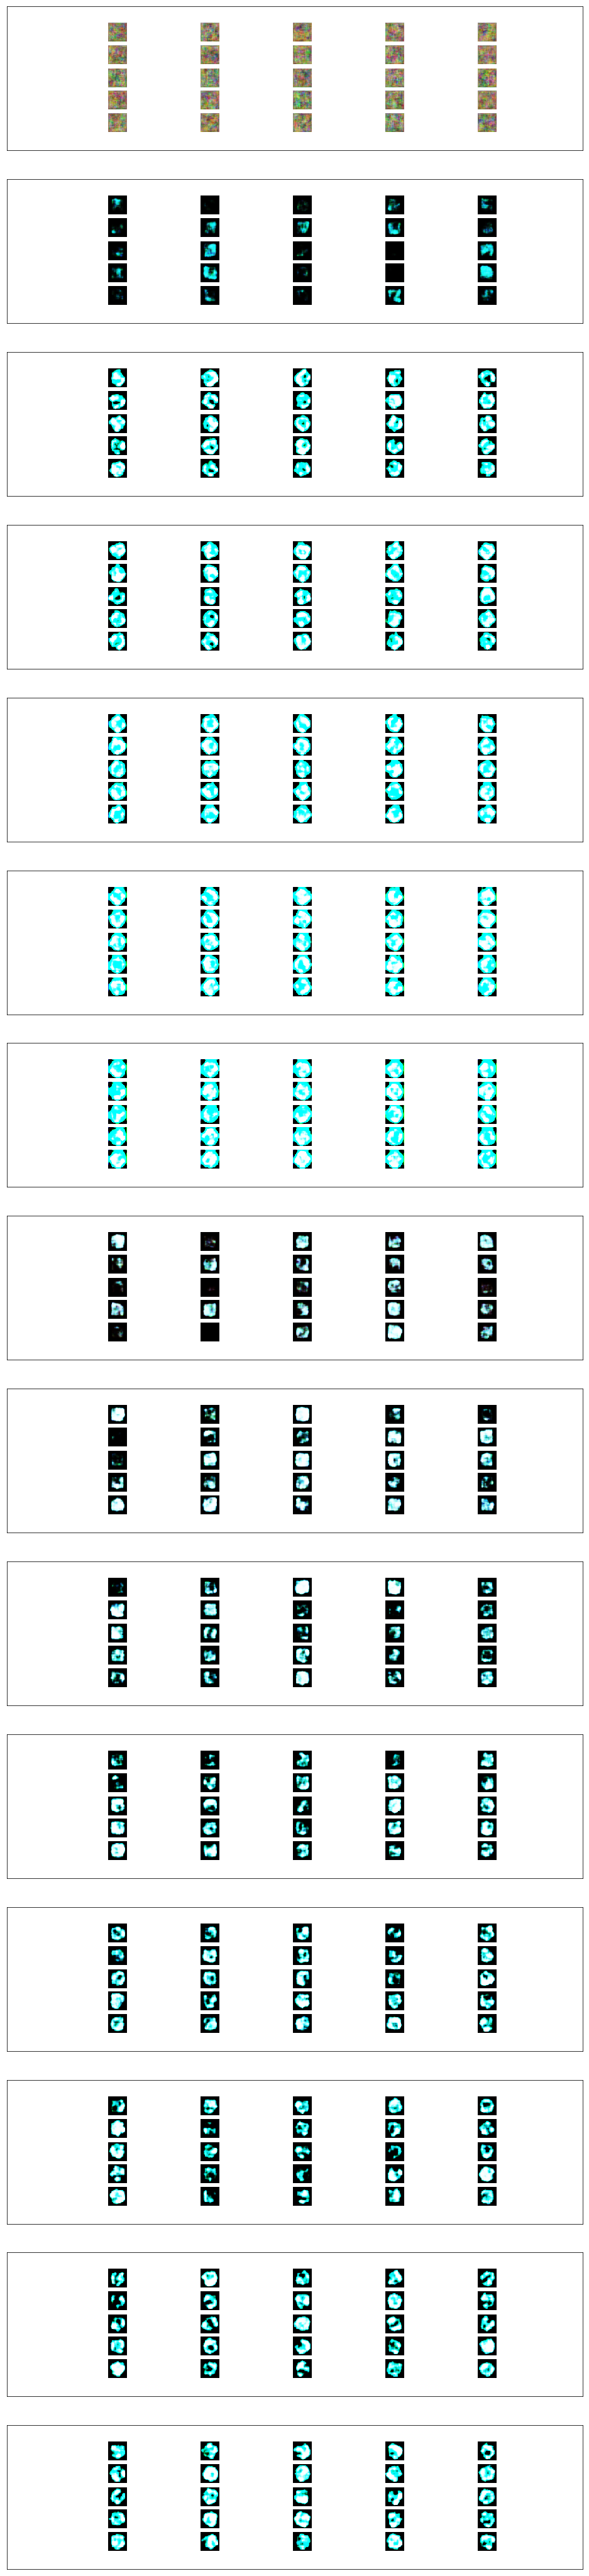

In [0]:
plot_test_img_dir(directory="generated_images", count=15)

## Generate test set from trained GAN

In [0]:
# from keras.models import load_model
# from keras import backend as K
# def save_test_images(epoch):
#         #Save 25 generated images for demonstration purposes using matplotlib.pyplot.
#         rows, columns = 2, 2
#         noise = np.random.normal(0, 1, (rows * columns, random_noise_dimension))
#         saved_model_path = 'saved_models/saved_model1.h5'
#         generator = load_model(saved_model_path)
#         generated_images = generator.predict(noise)

#         generated_images = 0.5 * generated_images + 0.5

#         figure, axis = plt.subplots(rows, columns)
#         image_count = 0
#         for row in range(rows):
#             for column in range(columns):
#                 axis[row,column].imshow(generated_images[image_count, :], cmap='spring')
#                 axis[row,column].axis('off')
#                 image_count += 1
#         figure.savefig("generated_test_images/generated_%d.png" % epoch)
#         plt.close()


In [0]:
# for i in range(0,3):
#   print("Saving image "+str(i))
#   save_test_images(i)

In [0]:
# def save_test_images_one(epoch):
#         #Save 25 generated images for demonstration purposes using matplotlib.pyplot.
#         rows, columns = 2, 2
#         noise = np.random.normal(0, 1, (rows * columns, random_noise_dimension))
#         saved_model_path = 'saved_models/saved_model1.h5'
#         generator = load_model(saved_model_path)
#         generated_images = generator.predict(noise)

#         generated_images = 0.5 * generated_images + 0.5

#         figure, axis = plt.subplots()
#         image_count = 0
        
#         axis.imshow(generated_images[1, :], cmap='spring')
#         axis.axis('off')
#         figure.savefig("generated_test_images/generated_%d.png" % epoch)
#         plt.close()


In [0]:
# for i in range(0,200):
#   print("Saving image "+str(i))
#   save_test_images_one(i)

## References

This code was adapted from: https://medium.com/datadriveninvestor/generating-human-faces-with-keras-3ccd54c17f16